In [43]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
matplotlib.style.use('ggplot')

from statsmodels.stats.weightstats import ztest
import statsmodels.api as sm
%matplotlib inline

np.random.seed(42)

## AB Tests

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

In [199]:
df_1 = pd.read_csv('dataset_part1_students.csv', sep="\\t")
df_1.head(5)

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656


In [200]:
df_1.describe()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2.075323,0.522300,0.501970,0.496674,0.501623,0.501036,0.497661,0.501234,0.497832,0.496958,0.499980,0.498894
std,3.035037,0.499515,0.288250,0.289476,0.289892,0.288132,0.288567,0.288967,0.287840,0.288291,0.288345,0.287987
min,-9.047982,0.000000,0.000159,0.000013,0.000057,0.000028,0.000004,0.000073,0.000110,0.000057,0.000012,0.000013
25%,0.026237,0.000000,0.251363,0.244871,0.251427,0.250494,0.250537,0.250726,0.249500,0.247673,0.251035,0.250138
50%,2.075935,1.000000,0.503203,0.496624,0.504957,0.498941,0.498581,0.499502,0.499507,0.492757,0.499955,0.500853
75%,4.140186,1.000000,0.751609,0.745780,0.753342,0.752575,0.746653,0.752015,0.744436,0.746960,0.748775,0.745164
max,13.895502,1.000000,0.999966,0.999936,0.999960,0.999987,0.999948,0.999885,0.999970,0.999913,0.999906,0.999982


Разбиваем выборку на контрольную(тестовую W=0) и целевую(W=1) группу.

In [201]:
test_group_1 = df_1[df_1['W'] == 0.0]
target_group_1 = df_1[df_1['W'] == 1.0]
print(test_group_1.head(5))
print(target_group_1.head(5))

           y    W       X_1       X_2  ...       X_7       X_8       X_9      X_10
0  -1.459404  0.0  0.986277  0.873392  ...  0.276477  0.343316  0.862159  0.156700
1  -1.694174  0.0  0.140887  0.757080  ...  0.217101  0.561427  0.124179  0.319736
2   5.378374  0.0  0.953214  0.137357  ...  0.034191  0.456119  0.155851  0.476049
8   7.043034  0.0  0.576548  0.177279  ...  0.871687  0.902407  0.449204  0.618182
11 -0.507666  0.0  0.040952  0.898553  ...  0.853931  0.609019  0.452414  0.296660

[5 rows x 12 columns]
          y    W       X_1       X_2  ...       X_7       X_8       X_9      X_10
3  2.188189  1.0  0.169702  0.896258  ...  0.583462  0.668350  0.177793  0.849248
4  2.862696  1.0  0.442373  0.831468  ...  0.636894  0.555696  0.191929  0.425656
5  3.051907  1.0  0.513420  0.269378  ...  0.564320  0.936032  0.803028  0.697305
6  3.094696  1.0  0.461384  0.662435  ...  0.894283  0.831532  0.737843  0.898497
7  0.530055  1.0  0.230734  0.179961  ...  0.952552  0.816207  0.0778

In [202]:
print('Размер контрольной группы:', test_group_1.size)
print('Размер целевой группы:', target_group_1.size)

Размер контрольной группы: 114648
Размер целевой группы: 125352


Размеры групп выбраны так, чтобы MDE было оптимальным(приблизительно равное количество наблюдений в обеих группах).

In [203]:
def plot_variables_hists(test_group, target_group):
  for column_name in test_group.columns:
    if not column_name.startswith('X_'):
      continue
    plt.hist(test_group[column_name], alpha=0.5)
    plt.hist(target_group[column_name], alpha=0.5)
    plt.show()

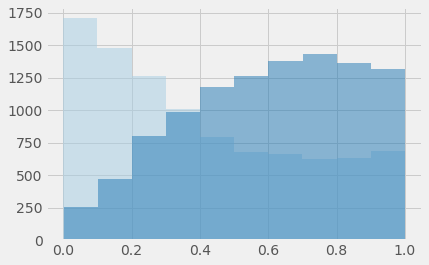

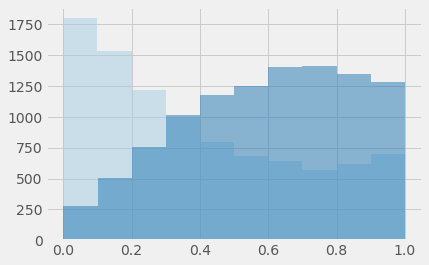

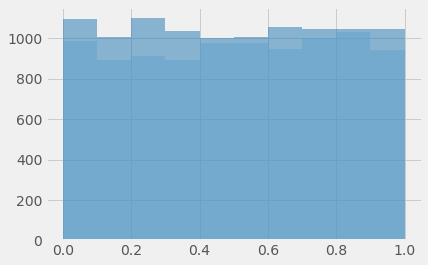

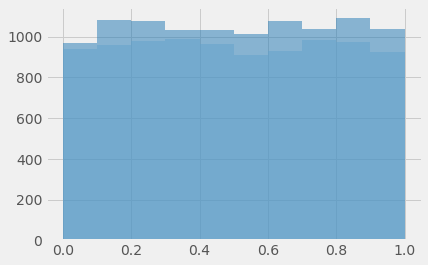

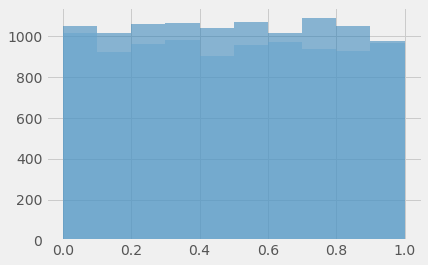

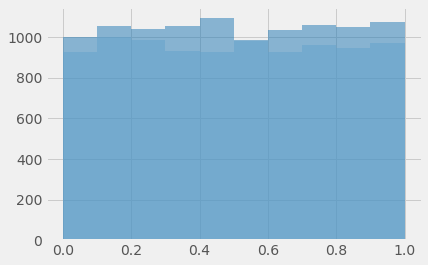

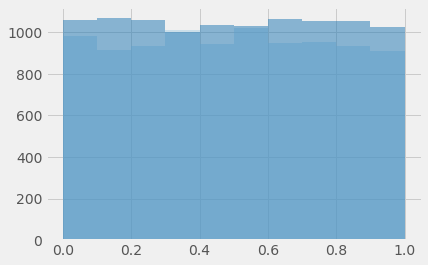

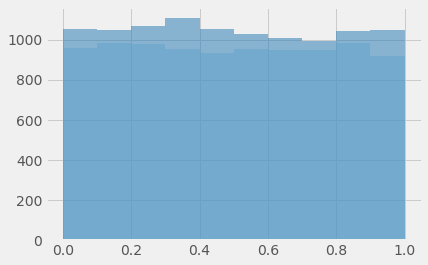

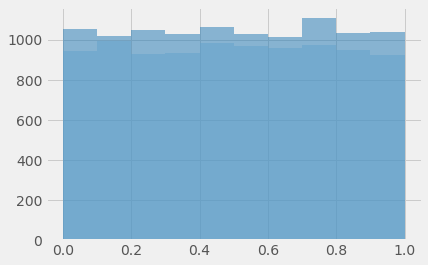

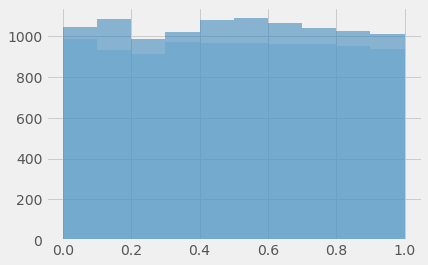

In [204]:
plot_variables_hists(test_group_1, target_group_1)

Для признаков Х_1 и Х_2 распределения получились неравномерные.Есть вероятность того, что эксперемент не является чисто рандомизированным. Однако для дальнейшего оценивания ATE будем предполагать, что данные хорошо рандомизированны.

Теперь необходимо проверить гипотезу о равенстве средних в контрольной и целевой группах. Для проверки данной гипотезы можно воспользоваться Z-критерием или t-критерием. 
Для начала рассмотрим Z-критерий. Для применения данного критерия необходимо, чтобы исходные данные имели нормальное распределение и была известна дисперсия генеральной совокупности. Дисперсия в нашем случае известна. Для проверки на нормальность распределения воспользуемся критерием Шапиро-УилкаШапиро-Уилка.

In [36]:
def is_norm_rasp(vect):
  _, res = stats.shapiro(vect)
  print('p-value', res)
  if res < 0.05:
    print('Распределение не явлется нормальным')
  else:
    print("Распределение нормальное")
  plt.hist(vect, bins=50)
  plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value 0.837329626083374
Распределение нормальное


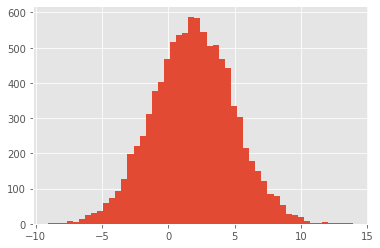

In [37]:
is_norm_rasp(test_group_1['y'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value 0.8599085807800293
Распределение нормальное


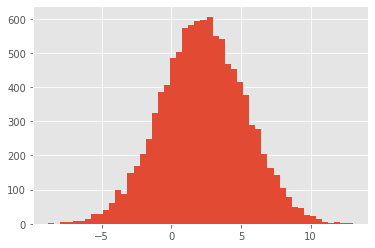

In [38]:
is_norm_rasp(target_group_1['y'])

Тест показал, что оба распределения нормальные. Проверим статестическую гипотезу о равенстве средних с помощью Z-критерия.

In [27]:
def two_histograms(x, y):
    """
    Функция, которая построит две гистограммы на одной картинке.
    Дополнительно пунктирными линиями указываются средние значения выборок.
    x: вектор pd.Series,
    y: вектор pd.Series
    """
    x.hist(alpha=0.5, weights=[1./len(x)]*len(x))
    y.hist(alpha=0.5, weights=[1./len(y)]*len(y))
    plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed')
    plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed')
    plt.legend([x.name, y.name])

In [34]:
def z_crit(vect1, vect2):
  _, pval = ztest(vect1, vect2)

  print('p-value', pval)
  if pval < 0.05:
    print('Средние не равны')
  else:
    print("Средние равны")
  two_histograms(vect1, vect2)

p-value 1.0349941796938945e-20
Средние не равны


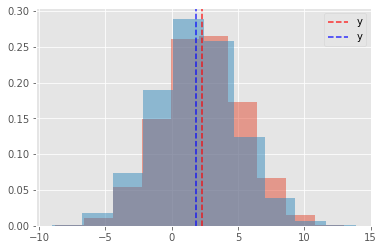

In [35]:
z_crit(target_group_1['y'], test_group_1['y'])

В результате получаем, что нулевая гипотеза отвернута, т.е. среднии двух выборок не равны.

Попробуем выполнить ту же самую проверку с помощью T-критерия. Для применения данного критерия необходимо, чтобы исходные данные имели нормальное распределение. В случае применения двухвыборочного критерия для независимых выборок также необходимо соблюдение условия равенства дисперсий. Существуют, однако, альтернативы критерию Стьюдента для ситуации с неравными дисперсиями.

Нормальность распределений мы уже установили.
Проверим c помощью критерия Флигнера-Килина, равны ли дисперсии.

In [39]:
def is_disps_equals(vect1, vect2):
  _, pval = stats.fligner(vect1, vect2)

  print('p-value', pval)
  if pval < 0.05:
    print('Дисперсии не равны')
  else:
    print("Дисперсии равны")

In [40]:
is_disps_equals(target_group_1['y'], test_group_1['y'])

p-value 0.8780501201261598
Дисперсии равны


Данный тест показал, что дисперсии равны. Теперь можно применять t-критерий.

In [90]:
def t_crit(vect1, vect2, eq_var=False):
  _, pval = stats.ttest_ind(vect1, vect2, equal_var = eq_var)

  print('p-value', pval)
  if pval < 0.05:
    print('Средние не равны')
  else:
    print("Средние равны")
  two_histograms(vect1, vect2)

p-value 1.1400916649505329e-20
Средние не равны


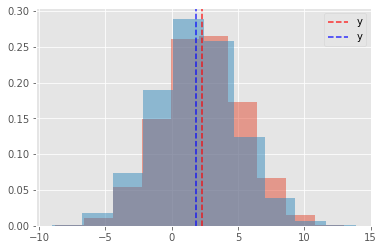

In [91]:
t_crit(target_group_1['y'], test_group_1['y'], True)

Данный тест также показал, что среднии двух выборок не равны.

Каков treatment effect нашего воздействия? (ATE)
Примените известные вам методы оценки ATE с учетом особенностей данных
Далее нам необходимо оценить treatment effect нашего воздействия. Однако, наши данные имеют такую особенность(известны только результаты после проведения A/B теста), что сделать это становится проблематично, так как в большинстве методов для оценки воздействия требуется знать данные до воздействия.Единственный метод, который можно использовать в данной ситуации -- это модификация метода ANCOVA, где вместо изначальных данных y_0 используются признаки объекта Х. 

Проведем оценку ATE.

In [74]:
def ancova(x, y):
  x['ones'] = 1.0

  model = sm.OLS(y, x)
  results = model.fit()

  print('treatment effect', results.params[0])


In [75]:
x = df_1.drop(columns=['y'], axis=1)
y = df_1['y']

ancova(x, y)

treatment effect 0.5133854882565578


То есть в среднем среднее значение после воздействия увеличилось на 0.5.

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

In [120]:
df_2 = pd.read_csv('dataset_part2_students.csv', sep="\\t")
df_2.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209


In [80]:
df_2.describe()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.104517,0.751393,0.524000,0.494608,0.503882,0.498649,0.500041,0.499651,0.496875,0.502681,0.500391,0.502482,0.498343
std,2.075276,2.292416,0.499449,0.287804,0.287356,0.290250,0.289479,0.289714,0.288792,0.289304,0.289625,0.286766,0.287541
min,-5.772625,-7.895281,0.000000,0.000103,0.000027,0.000052,0.000086,0.000049,0.000002,0.000092,0.000053,0.000286,0.000036
25%,0.720403,-0.778216,0.000000,0.245372,0.255875,0.248544,0.248120,0.245991,0.243503,0.252856,0.249906,0.256388,0.251672
50%,2.088402,0.745162,1.000000,0.490941,0.504934,0.492483,0.498955,0.496116,0.497895,0.501308,0.497964,0.504018,0.492807
75%,3.482478,2.343497,1.000000,0.743003,0.750596,0.751100,0.753792,0.753868,0.743828,0.752798,0.753477,0.749514,0.749355
max,10.488659,9.988961,1.000000,0.999685,0.999707,0.999982,0.999913,0.999935,0.999989,0.999964,0.999944,0.999981,0.999915


In [121]:
test_group_2 = df_2[df_2['W'] == 0.0]
target_group_2 = df_2[df_2['W'] == 1.0]
print(test_group_2.head(5))
print(target_group_2.head(5))


        y_1       y_0    W       X_1  ...       X_7       X_8       X_9      X_10
1  2.232601  5.533515  0.0  0.096894  ...  0.616525  0.963843  0.574304  0.371161
4  2.163090  1.365405  0.0  0.442232  ...  0.890655  0.588886  0.636830  0.342209
5 -1.808257  0.025748  0.0  0.823791  ...  0.154615  0.388699  0.647614  0.848299
6  0.614170 -0.808566  0.0  0.063836  ...  0.090867  0.874557  0.776977  0.771566
7  3.103859  1.938065  0.0  0.063103  ...  0.678729  0.754377  0.417257  0.320899

[5 rows x 13 columns]
        y_1       y_0    W       X_1  ...       X_7       X_8       X_9      X_10
0  5.887156  2.785060  1.0  0.605978  ...  0.178993  0.752925  0.662161  0.784310
2  0.144419  0.095546  1.0  0.452145  ...  0.517814  0.823099  0.732225  0.069056
3 -2.446425  3.590472  1.0  0.672129  ...  0.301069  0.871741  0.589654  0.981770
8  3.592016  3.985938  1.0  0.372296  ...  0.330489  0.966714  0.825899  0.305400
9  0.033735  2.688234  1.0  0.823278  ...  0.648545  0.343327  0.622637  0.

In [82]:
print(test_group_2.size)
print(target_group_2.size)

61880
68120


Выборка разделена на две группы практически пополам, значит MDE оптимальный.

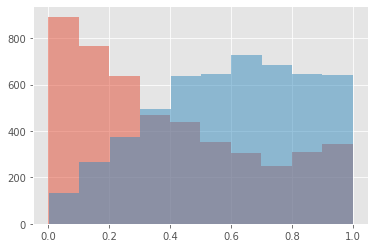

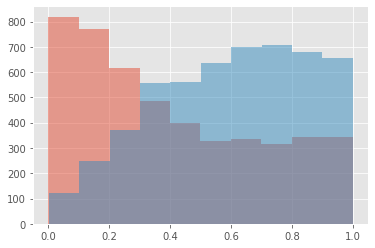

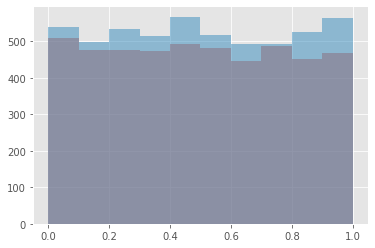

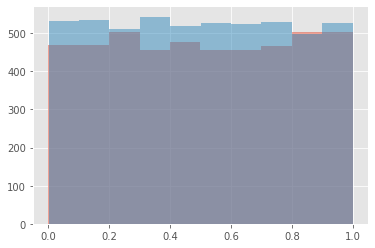

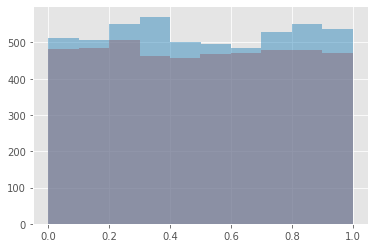

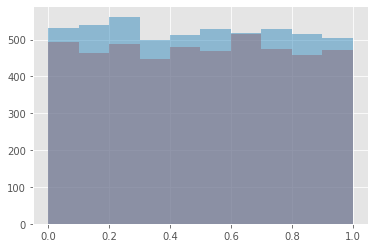

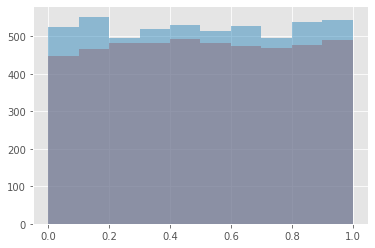

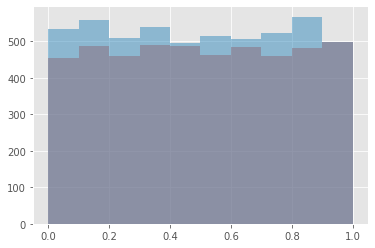

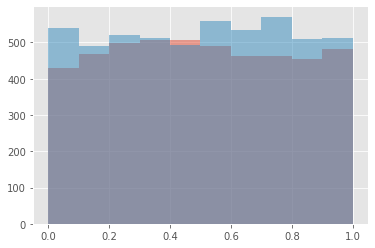

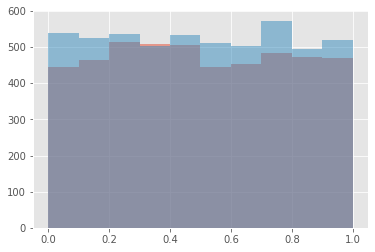

In [88]:
plot_variables_hists(test_group_2, target_group_2)

Выборка разбита на две группы неравномерно по признакам Х_1 и Х_2, значит эксперемент не совсем рандомизированный. Однако для дальнейшего оценивания ATE будем предполагать, что данные хорошо рандомизированны.

У нас имеется две группы наблюдений -- контрольная и целевая. для каждой группы имеются результаты до и после проведения A/B теста. Нам нужно понять, прошел ли тест удачно, для этого необходимо сравнить средние значения после проведения теста. Но для того, чтобы результат сравнения был точным необходимо, чтобы средние были равны до проведения теста.
Также можно посмотреть равны ли средние по приросту результата(y_1 - y_0)


Для начала проверим гипотезу о равенстве средних в начальный момент времени. Для этого необходимо проверить нормальность распределения и равенство дисперсий.

p-value 0.5011960864067078
Распределение нормальное


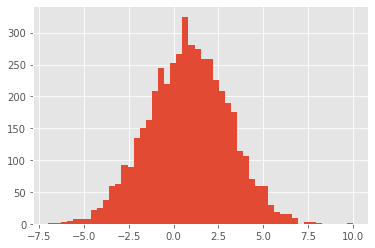

In [85]:
is_norm_rasp(test_group_2['y_0'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value 0.7005389332771301
Распределение нормальное


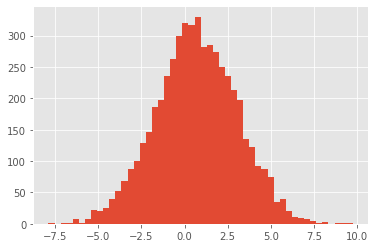

In [86]:
is_norm_rasp(target_group_2['y_0'])

Тесты показали, что оба распределения нормальные.

In [89]:
is_disps_equals(test_group_2['y_0'], target_group_2['y_0'])

p-value 0.0011111631081886838
Дисперсии не равны


Тест показал, что дисперсии не равны. Теперь проверим равенство средних с помощью t-критерия с параметром для разных дисперсий.

p-value 0.0069160683710655525
Средние не равны


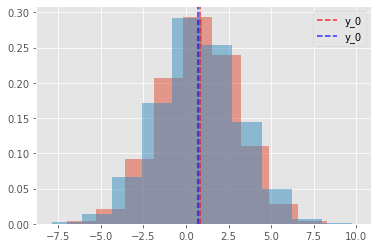

In [92]:
t_crit(test_group_2['y_0'], target_group_2['y_0'])

Тест показал, что средние по двум выборкам в начальный момент различны. Значит, нет смысла сравнивать среднии после воздействия, так как тест будет не показательным. Поэтому сравним средние по приросту результата.
Но для начала нужно проверить распределения значений y_1 - y_0 для двух выборок и посмотреть, равны ли их дисперсии.

p-value 0.17446228861808777
Распределение нормальное


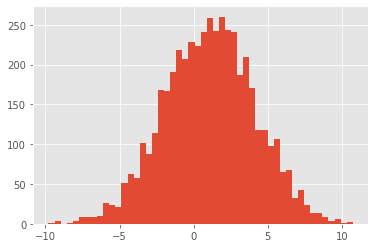

In [94]:
is_norm_rasp(test_group_2['y_1']-test_group_2['y_0'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value 0.38465145230293274
Распределение нормальное


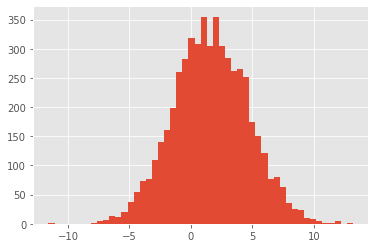

In [95]:
is_norm_rasp(target_group_2['y_1']-target_group_2['y_0'])

In [96]:
is_disps_equals(test_group_2['y_1']-test_group_2['y_0'], target_group_2['y_1']-target_group_2['y_0'])

p-value 0.9842194800359902
Дисперсии равны


Тесты показали, что распределения нормальные и дисперсии равны. Можно применять критерий равенства средних(t-тест).

p-value 9.12276266827303e-20
Средние не равны


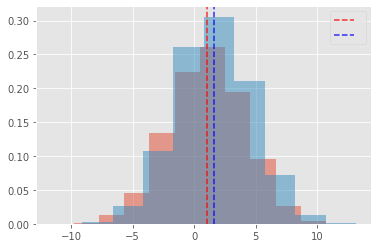

In [97]:
t_crit(test_group_2['y_1']-test_group_2['y_0'], target_group_2['y_1']-target_group_2['y_0'], eq_var=True)

Тест показал, что средний прирост результата в двух группах различается.

Теперь нужно оценить ATE. для начала попробуем использовать самый простой способ оценки -- линейную регрессию.

In [142]:
def linear_reg(x, y):
  x['ones'] = 1.0
  model = sm.OLS(y, x)
  results = model.fit()

  print('treatment effect', results.params[0])

In [143]:
y = df_2['y_1'] - df_2['y_0']
x = df_2.drop(['y_0', 'y_1'], axis=1)
linear_reg(x, y)


treatment effect 0.5425071531832277


Из-за того, что среднее в начальный момент в выборках смещено, то линейная регресиия дала смещенную оценку. Так как средние на старте в данных группах различны, то будет логично применить метод Difference in differences.

In [144]:
def did(df):
  y_0 = df['y_0']
  y_1 = df['y_1']
  y = np.hstack((y_0, y_1)).reshape(-1, 1)
  alpha = np.ones(y.shape)
  T_0 = np.zeros(y_0.shape)
  T_1 = np.ones(y_1.shape)
  T = np.hstack((T_0, T_1)).reshape(-1, 1)
  W_1 = df['W']
  W = np.hstack((W_1, W_1)).reshape(-1, 1)
  TW = np.hstack((T_0, W_1)).reshape(-1, 1)
  x_arr = np.hstack((alpha, T, W, TW))

  model = sm.OLS(y, x_arr)
  results = model.fit()

  DID_ATE = results.params[3]
  print('treatment effect', results.params[3])

  plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
  fig, ax = plt.subplots()
  diff_target = (df[df['W'] == 1.0]['y_1'].mean() + (df[df['W'] == 0.0]['y_0'].mean() - df[df['W'] == 1.0]['y_0'].mean()))
  lineNJ, = ax.plot(['0', '1'], [df[df['W'] == 0.0]['y_0'].mean(), df[df['W'] == 0.0]['y_1'].mean()],color='blue',label='test_group before and after')
  linePA, = ax.plot(['0', '1'], [df[df['W'] == 1.0]['y_0'].mean(), df[df['W'] == 1.0]['y_1'].mean()],color = 'red',label = 'target_group before and after')
  lineNJ0, = ax.plot(['0', '1'], [df[df['W'] == 0.0]['y_0'].mean(), diff_target],color = 'red',linestyle='dashed',label='difference terget')
  ax.legend()
  plt.ylim(0, 3)  
  plt.title("Difference-in-differences: Before and After", fontsize="14")


treatment effect 0.5549047702971174


<Figure size 320x240 with 0 Axes>

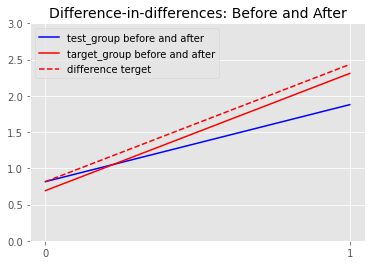

In [145]:
did(df_2)

Можно заметить, что результаты оценки ATE получились немного смещенными.


Cuped

In [147]:
def cuped(df):
  cov = ((df['y_1'] - df['y_1'].mean()) * (df['y_0'] - df['y_0'].mean())).sum() / df.shape[0]
  tetta = cov / np.var(df['y_0'])
  y_cuped = df['y_1'] - (df['y_0'] - df['y_0'].mean()) * tetta
  print(y_cuped.mean())
  print(df['y_1'].mean())
  print(np.var(y_cuped))
  print(np.var(df['y_1']))

In [148]:
cuped(df_2)

2.104517421073833
2.1045174210738353
4.3034106593815915
4.306339749101811


Применив метод увеличения мощности CUPED мы получили, что дисперсия уменьшилась незначительно(так как она и в начале была небольшой), поэтому искать ATE по y_cuped не имеет смысла.

ANCOVA

In [76]:
x = df_2[['W', 'y_0']]
y = df_2['y_1']
ancova(x, y)

treatment effect 0.43448638144565055


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Так как при данной модификации ANCOVA не учитываются признаки объектов, то не учитываются поправки на неравномерность распределения эффекта и значение ATE получается не точным.

In [77]:
x = df_2.drop(columns=['y_0', 'y_1'], axis=1)
y = df_2['y_1']
ancova(x, y)

treatment effect 0.54819353431793


В данной вариации метода учитываются признаки модели, поэтому результат получился похожим на результат, полученный с помощью линейной регрессии и метода Difference in differences.

Таким образом, все три модели оценки ATE показали примерно одинаковый результат(кроме метода ANCOVA без учета Х, так как еще в самом начале мы выяснили, что выборка разбита на две группы неравномерно по признакам Х_1 и Х_2). 

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.






Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

In [164]:
df_3 = pd.read_csv('dataset_part3_students.csv', sep="\\t")
df_3.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0


In [175]:
df_3['conversion'].value_counts()

0    169413
1     30587
Name: conversion, dtype: int64

In [165]:
df_3.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,-0.366881,1.000991,0.001935,-0.756540,1.000084,-1.667107,1.000705,-0.000710,-0.756540,0.005147,-0.001179,0.001210,0.000445,0.000694,-0.001166,0.730801,0.724893,0.729323,0.713093,-0.454716,0.454133,-0.226181,0.152935
std,0.747049,1.260868,1.004051,1.374899,1.244811,2.063263,1.040636,0.999507,1.374899,1.001864,1.001020,1.002052,1.000733,0.997000,0.999781,1.295677,1.156846,1.376184,1.125988,1.454906,1.343870,0.882719,0.359926
min,-4.260103,-4.369495,-4.670829,-5.754862,-5.983915,-10.220168,-4.166615,-4.227920,-5.754862,-4.777980,-4.546409,-4.445577,-4.550388,-4.528661,-4.401616,-5.578769,-5.638730,-4.638177,-3.808153,-6.811223,-4.291047,-4.069459,0.000000
25%,-0.862987,0.149688,-0.672525,-1.661703,0.167853,-3.060503,0.315748,-0.675240,-1.661703,-0.672295,-0.675308,-0.676829,-0.672417,-0.669325,-0.678250,-0.098053,0.104129,-0.228769,-0.067630,-1.525196,-0.547735,-0.837005,0.000000
50%,-0.373147,0.999645,0.005157,-0.864479,1.001572,-1.686846,0.999920,-0.001920,-0.864479,0.007714,0.000699,0.001778,0.001085,-0.002532,-0.000079,0.800327,0.839588,0.764489,0.740424,-0.372879,0.506115,-0.193615,0.000000
75%,0.120436,1.851332,0.680293,-0.012428,1.832482,-0.296865,1.682196,0.671658,-0.012428,0.678861,0.675092,0.677818,0.676277,0.671813,0.670672,1.620866,1.500485,1.686777,1.495407,0.747596,1.431963,0.411282,0.000000
max,4.121888,6.726024,4.976332,9.593777,6.820825,9.094394,7.081333,5.439752,9.593777,4.325225,4.957473,4.247420,4.873599,4.482854,5.125249,5.660769,4.982925,6.418469,5.431105,5.147421,6.085848,3.196679,1.000000


In [168]:
test_group_3 = df_3[df_3['treatment'] == 'control']
target_group_3 = df_3[df_3['treatment'] == 'treatment']
print(test_group_3.head(5))
print(target_group_3.head(5))


  treatment       X_1       X_2  ...      X_21      X_22  conversion
0   control  0.034351  0.550725  ...  1.929914  0.798664           0
1   control -1.059404  0.299404  ...  0.188000 -1.134651           0
2   control  0.051934  2.338729  ... -0.888490 -1.402561           0
4   control -1.416158  2.486628  ...  0.972459 -0.711251           0
7   control -2.410102  2.830583  ... -1.446302  0.899446           1

[5 rows x 24 columns]
    treatment       X_1       X_2  ...      X_21      X_22  conversion
3   treatment  0.667770  0.539316  ... -0.390745 -1.578004           1
5   treatment -1.793243  2.198746  ...  1.974227  1.612162           0
6   treatment -0.837370  2.013852  ... -1.317740  0.786878           0
9   treatment -0.216465  0.905275  ...  0.177017 -1.838169           0
10  treatment -1.027473  2.389843  ... -0.011218 -1.080762           0

[5 rows x 24 columns]


In [177]:
df_3['treatment'].value_counts()

treatment    100000
control      100000
Name: treatment, dtype: int64

Данная выборка также разбита на равные группы, значит MDE оптимальный.

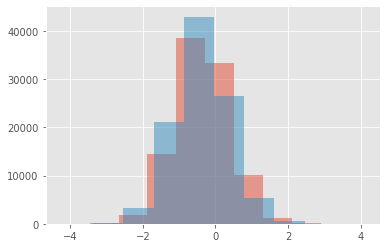

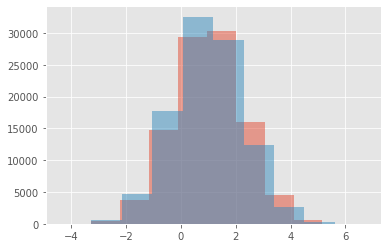

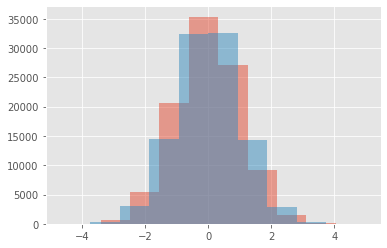

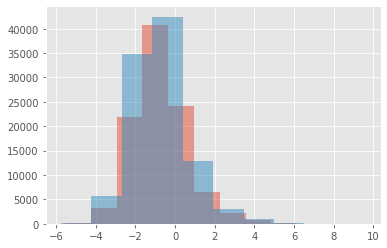

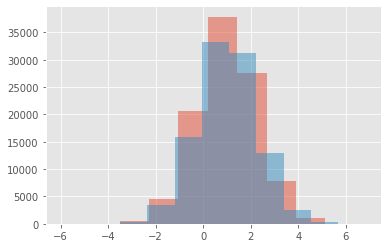

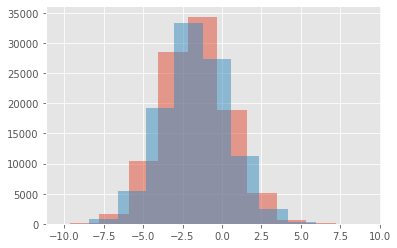

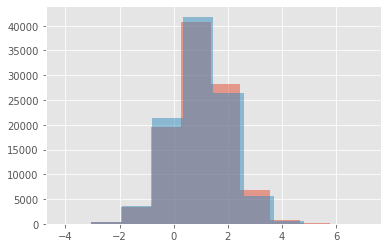

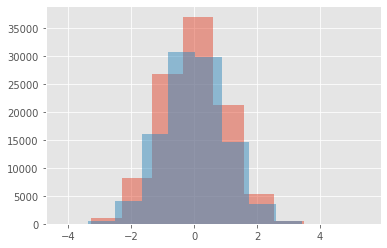

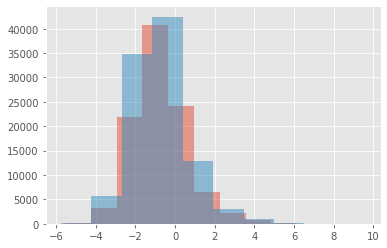

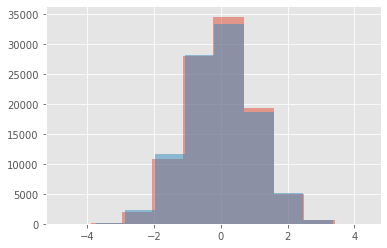

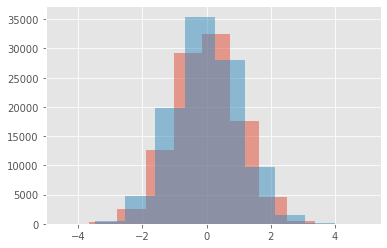

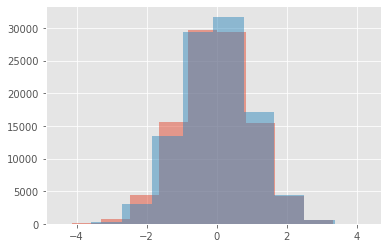

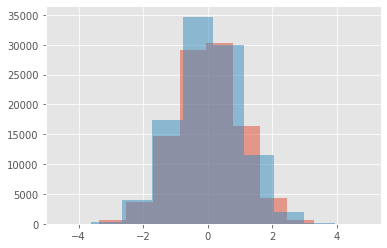

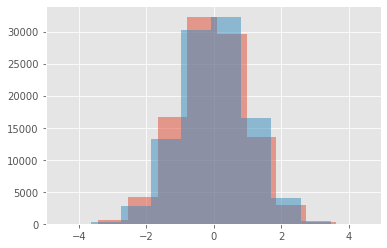

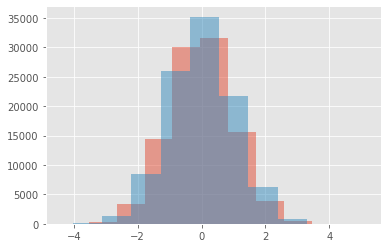

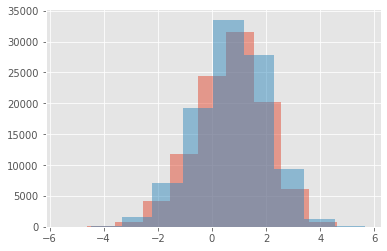

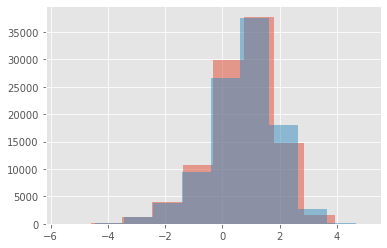

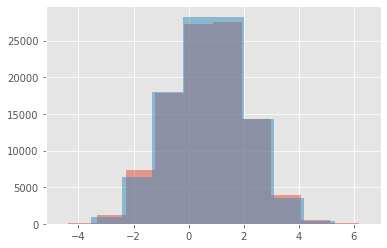

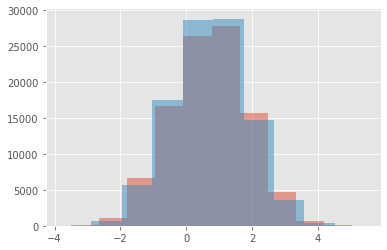

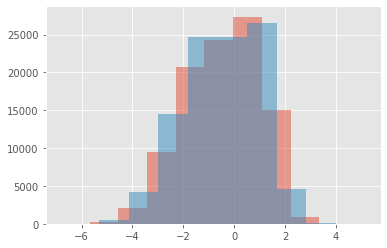

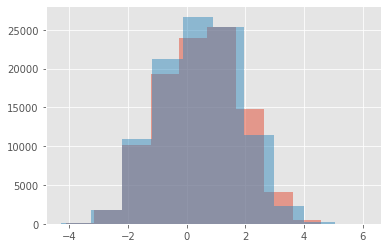

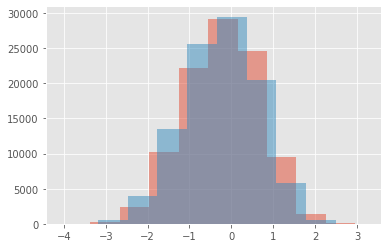

In [170]:
plot_variables_hists(test_group_3, target_group_3)

Из графиков видно, что распределение по группам не зависит от признаков. Можно сделать вывод, что эксперимент хорошо рандомизирован.

Оценка ATE

Исходя из особенностей данных не получится использовать подходы, которые использовались раньше, так как неизвестны начальные и конечные результаты, имеется только разница между ними. Поэтому используем метод из библиотеки causalml.

In [ ]:
!pip install causalml

In [184]:
from sklearn.model_selection import train_test_split
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import LRSRegressor

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [188]:
regressor = LRSRegressor(control_name='control')
ate, lower_ate, upper_ate = regressor.estimate_ate(df_3.drop(['conversion', 'treatment'], axis=1).values,
                                          df_3['treatment'].values, df_3['conversion'].values)
print("ATE {} lower bound {} upper bound {}".format(ate, lower_ate, upper_ate))

ATE [0.06024252] lower bound [0.05763117] upper bound [0.06285388]


Оценка ATE получена с помощью LRSRegressor из библиотеки causalml. Для ATE сразу рассчитываются верхняя и нижняя граница.

CATE

In [189]:
df_train, _ = train_test_split(df_3, test_size=0.25, random_state=42)

In [194]:
uplift_model = UpliftRandomForestClassifier(control_name='control', n_estimators=10, n_jobs=1)

In [195]:
uplift_model.fit(df_train.drop(['conversion', 'treatment'], axis=1).values,
                 treatment=df_train['treatment'].values,
                 y = df_train['conversion'].values)

In [196]:
scores = uplift_model.predict(df_3.drop(['conversion', 'treatment'], axis=1).values, full_output=True)

In [197]:
scores.head()

,treatment,control,recommended_treatment,delta_treatment,max_delta
0,0.185137,0.095598,0,0.089539,0.089539
1,0.128807,0.110889,0,0.017918,0.017918
2,0.124571,0.119979,0,0.004592,0.004592
3,0.404646,0.103024,0,0.301622,0.301622
4,0.103417,0.095712,0,0.007705,0.007705


В данной таблице представлены рекомендации к воздействию на каждый объект(recommended_treatment).Также в колонке delta_treatment представлены оценки CATE.

Рассчитаем ожидаемую конверсию при оптимальном воздействии:

In [198]:
summary = uplift_model.predict(df_3.drop(['conversion', 'treatment'], axis=1).values).sum()
print("Суммарная конверсия при оптимальном воздействии: {}".format(summary))

Суммарная конверсия при оптимальном воздействии: 11715.312273600002
